<img src="img/Logo_OpenClassrooms.png" width=100 />

# OpenClassrooms Projet 5: Segmentez des clients d'un site e-commerce
# Analyse Exploratoire

Olist souhaite que vous fournissiez à ses équipes d'e-commerce une segmentation des clients qu’elles pourront utiliser au quotidien pour leurs campagnes de communication.

Votre objectif est de comprendre les différents types d’utilisateurs grâce à leur comportement et à leurs données personnelles.

Vous devrez fournir à l’équipe marketing une description actionable de votre segmentation et de sa logique sous-jacente pour une utilisation optimale, ainsi qu’une proposition de contrat de maintenance basée sur une analyse de la stabilité des segments au cours du temps.

### Les données
Pour cette mission, Olist vous fournit une base de données anonymisée comportant des informations sur l’historique de commandes, les produits achetés, les commentaires de satisfaction, et la localisation des clients depuis janvier 2017.

### Votre mission
Votre mission est d’aider les équipes d’Olist à comprendre les différents types d'utilisateurs. Vous utiliserez donc des méthodes non supervisées pour regrouper ensemble des clients de profils similaires. Ces catégories pourront être utilisées par l’équipe marketing pour mieux communiquer.

Pour des raisons de confidentialité, Olist ne fournit pas beaucoup de données, à vous de fouiller dans celles dont vous disposez et de créer les meilleures features pour les exploiter.

Enfin, votre client, Olist, a spécifié sa demande ainsi :

- La segmentation proposée doit être exploitable et facile d’utilisation pour l’équipe marketing.
- Vous évaluerez la fréquence à laquelle la segmentation doit être mise à jour, afin de pouvoir effectuer un devis de contrat de maintenance.
- Le code fourni doit respecter la convention PEP8, pour être utilisable par Olist.


# Sommaire
### [Bibliothèques](#1_bibli)
### [Fonctions](#1_funcs)
### [Données](#1_donnees)
### [Création de la base](#1_creation_base)
### [Transformation pour Modélisation](#model)

<a id='1_bibli'></a>
# Import de bibliothèques 📚

In [1]:
import pandas as pd
pd.set_option("mode.chained_assignment", None)
import numpy as np
from fuzzywuzzy import fuzz
import matplotlib.pyplot as plt

C:\Users\S053567\Anaconda3\lib\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


<a id='1_funcs'></a>

# Fonctions ⚙️

<a id='get_orders'></a>

In [2]:
def get_orders(client_unique_id):
    """ A partir d'un id client unique la fonction retourne la liste des commandes correspondantes,
    La table des commandes doit au préalable être filtrée en fonction de la date virtuelle de l'étude
    Args:
        client_unique_id
    """
    
    # Avec l'id unique du client on récupère les id clients qui sont liés à chaque commande
    ids_client = customers[customers['customer_unique_id'] == client_unique_id].customer_id.values
    # On peut ensuite récupérer les id des commandes correspondant à ces ids clients
    orders_client = orders[orders.customer_id.isin(ids_client)]
    # On récupère juste les ids
    ids_orders_client = orders_client.index.values
    return ids_orders_client

[Retour au code](#get_orders_back)

<a id='get_nb_days'></a>

In [3]:
def get_nb_days(row, virtual_date, orders):
    """
    Cette fonction calcule le nombre de jours écoulés depuis la première et la dernière 
    commande en prenant pour référence la date virtuelle de l'étude.
    Args :
        row: Pandas DataFrame row (Series) avec un attribut "orders_ids"
        Timestamp 
        Pandas DataFrame : avec les données des commandes
    Returns :
        Tuple
    """
    orders_ids = row.orders_ids
    
    date_first_order = orders.loc[orders_ids[0], 'order_purchase_timestamp']
    date_last_order = orders.loc[orders_ids[-1], 'order_purchase_timestamp']
    
    since_first = (virtual_date - date_first_order).days
    since_last = (virtual_date - date_last_order).days
    return since_first, since_last

[Retour au code](#tps_last_order)

<a id='get_frequency'></a>

In [4]:
def get_frequency(row):
    """
    Calcul du nombre de commandes par mois entre la première commande
    et la date virtuelle.
    """
    return row.nb_orders / row.days_since_first_order * 365.25 / 12

[Retour au code](#frequence)

<a id='get_sum_orders'></a>

In [5]:
def get_sum_orders(row):
    """
    Calcule la somme des montants des commandes
    """
    return order_items[order_items.index.isin(row.orders_ids)].price.sum()    

[Retour au code](#montant)

<a id='get_most_frequent_categ'></a>

In [6]:
def get_most_frequent_categ(row):
    """
    Retourne la catégorie qui revient le plus souvent dans les achats. 
    En cas d'égalité on prend la première donnée par value_counts()
    """
    
    orders_ids = row.orders_ids

    products_ids = order_items[order_items.index.isin(row.orders_ids)].product_id
    products_client = products[products.index.isin(products_ids)]

    try:
        return products_client.product_category_name.value_counts().index[0]
    except:
        print('fail')
        if len(products_client.product_category_name.value_counts().index) > 1:
            return products_client.product_category_name.value_counts().index[1]
        else :
            return np.nan

[Retour au code](#categorie)

<a id='get_nb_reviews_and_avg'></a>

In [7]:
def get_nb_reviews_and_avg(row):
    """
    Recupère le nombre de reviews et la note moyenne
    """
    orders_ids = row.orders_ids
    client_reviews = reviews[reviews.order_id.isin(orders_ids)]
    if len(client_reviews) > 0:
        return len(client_reviews), client_reviews.review_score.mean()
    else:
        return 0, np.nan

[Retour au code](#reviews)

<a id='get_favourite_payment_method'></a>

In [8]:
def get_favourite_payment_method(row):
    """
    Retourne le type de paiement préféré du client
    """
    orders_ids = row.orders_ids
    payment_methods = payments[payments.order_id.isin(orders_ids)].payment_type.value_counts()
    return payment_methods.index[0]

[Retour au code](#mode_paiement_prefere)

<a id='get_delivery_time_and_delays'></a>

In [9]:
def get_delivery_time_and_delays(row):
    """
    Pour les clients ayant eu des commandes ayant abouties, on calcule le taux d'avance, de retard et le temps moyen de livraison
    """
    client_orders = orders[orders.index.isin(row.orders_ids)]
    client_orders = client_orders[client_orders.order_status == 'delivered']
    
    if client_orders.shape[0] > 0:
        was_delayed_counts = client_orders.was_delayed.value_counts(normalize=True)
        if True in was_delayed_counts.index:
            delay_rate = was_delayed_counts.loc[True]
        else:
            delay_rate = 0
        was_in_advance_counts = client_orders.was_in_advance.value_counts(normalize=True)
        if True in was_in_advance_counts.index:
            advance_rate = was_in_advance_counts.loc[True]
        else:
            advance_rate = 0
        return client_orders.delivery_time.mean(), delay_rate, advance_rate
    else:
        np.nan, np.nan, np.nan

[Retour au code](#tps_livraison)

<a id='get_cancelation_rate'></a>

In [10]:
def get_cancelation_rate(row):
    client_orders = orders[orders.index.isin(row.orders_ids)]
    status_counts = client_orders.order_status.value_counts(normalize=True)
    if 'canceled' in status_counts.index:
        return status_counts.loc['canceled']
    else:
        return 0

[Retour au code](#annulation)

<a id='1_donnees'></a>

# Données 🎁

<img src="img/structure.png" width=500 />

In [11]:
orders = pd.read_csv('data/olist_orders_dataset.csv', index_col='order_id',parse_dates=['order_purchase_timestamp', 
                                                                                        'order_approved_at',	
                                                                                        'order_delivered_carrier_date',	
                                                                                        'order_delivered_customer_date',
                                                                                        'order_estimated_delivery_date'])
order_items = pd.read_csv('data/olist_order_items_dataset.csv',  index_col='order_id')
products = pd.read_csv('data/olist_products_dataset.csv', index_col='product_id', na_values=np.nan)
customers = pd.read_csv('data/olist_customers_dataset.csv')
reviews = pd.read_csv('data/olist_order_reviews_dataset.csv')
geolocs = pd.read_csv('data/olist_geolocation_dataset.csv')
payments = pd.read_csv('data/olist_order_payments_dataset.csv')
products_categ_traduction = pd.read_csv('data/product_category_name_translation.csv')

Application de la traduction des catégories de produits:

In [12]:
products = products.merge(products_categ_traduction, how='left').set_axis(products.index)

In [13]:
products_categ_traduction.shape[0] == len(products.product_category_name.unique())

False

<a id='1_creation_base'></a>

# Création d'une base répondant au besoin ✅
La base doit avoir pour index les ids des clients avec des variables en relation avec son comportement.

Variables retenues:
- [Nombre de commandes](#nb_commandes)
- [Temps depuis la première et la dernière commande](#tps_last_order)
- [Fréquence achats](#frequence)
- [Montants dépensés](#montant)
- [Catégorie de produit la plus fréquente](#categorie)
- [Nombre d'avis postés et note moyenne](#reviews)
- [Mode de paiement préféré](#mode_paiement_prefere)
- [Temps de livraison et retards](#tps_livraison)
- [Taux d'annulation des commandes](#annulation)

### Important:
Pour le bon fonctionnement du projet, les fonctions développées pour la constitution de la base prendront en paramètre la date à laquelle on veut se fixer virtuellement. En effet on cherchera plus tard dans ce projet à déterminer la fréquence de mise à jour de la base d'entrainement du modèle.
On prendra toujours dans ce notebook la dernière date de la base de donnée.

In [14]:
virtual_date = orders.order_purchase_timestamp.max()

In [15]:
orders.order_purchase_timestamp.max()

Timestamp('2018-10-17 17:30:18')

<a id='nb_commandes'></a>

## Nombre de commandes par client 🥰

Cette variable est la plus importante car va nous permettre de connaitre la taille de notre dataset. En effet, difficile de classer des clients n'ayant fait qu'une commande

Regardons comment fonctionnent les id des clients

In [16]:
customers.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP


In [17]:
len(customers.customer_unique_id.unique())

96096

In [18]:
len(customers.customer_id.unique())

99441

In [19]:
orders.columns

Index(['customer_id', 'order_status', 'order_purchase_timestamp',
       'order_approved_at', 'order_delivered_carrier_date',
       'order_delivered_customer_date', 'order_estimated_delivery_date'],
      dtype='object')

On filtre ici la date virtuelle pour garder un trace mais cette commande est neutre

In [20]:
orders = orders[orders.order_purchase_timestamp <= virtual_date]

In [21]:
orders = orders.merge(customers[['customer_id', 'customer_unique_id']], how='left').set_axis(orders.index)

On trie par date pour conserver un ordre des commandes logique

In [22]:
orders.sort_values('order_purchase_timestamp', inplace=True)

In [23]:
(orders.groupby('customer_unique_id').count().customer_id > 1).value_counts()

False    93099
True      2997
Name: customer_id, dtype: int64

### Il n'y a dans la base clients que 2997 clients ayant fait plus d'un commande

In [24]:
data = pd.DataFrame(orders.groupby('customer_unique_id').count().customer_id)

In [25]:
data.columns = ['nb_orders']

In [26]:
data.nb_orders.value_counts().values

array([93099,  2745,   203,    30,     8,     6,     3,     1,     1],
      dtype=int64)

In [27]:
nb_orders_data = data.nb_orders.value_counts()

In [28]:
data.nb_orders.value_counts(normalize=True)

1     0.968812
2     0.028565
3     0.002112
4     0.000312
5     0.000083
6     0.000062
7     0.000031
9     0.000010
17    0.000010
Name: nb_orders, dtype: float64

Text(0.5, 0, 'Nombre de commandes')

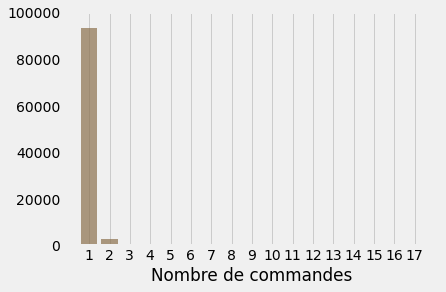

In [29]:
plt.style.use('fivethirtyeight')
plt.bar(nb_orders_data.index,
        nb_orders_data.values,
       color="#8c704d",
       alpha=0.7)
plt.grid(False, axis='y')
plt.xticks(range(1,18))
plt.yticks(np.arange(0, 120e3, 20e3))
plt.xlabel("Nombre de commandes")
# plt.savefig('plots/nb_orders.png',  bbox_inches='tight', dpi=360)

Nous avons besoin de clients ayant plus d'une commande pour commencer à comprendre leur comportement. Cela réduit considérablement la taille de la base

In [30]:
data = data[data.nb_orders > 1]

In [31]:
nb_orders_data_reduced = nb_orders_data[nb_orders_data.index > 1]

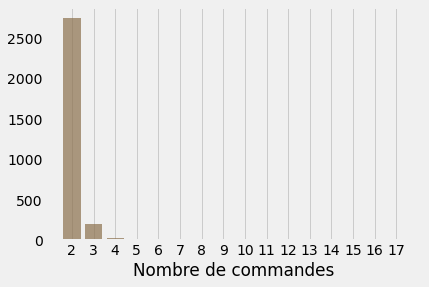

In [32]:
plt.style.use('fivethirtyeight')
plt.bar(nb_orders_data_reduced.index,
        nb_orders_data_reduced.values,
       color="#8c704d",
       alpha=0.7)
plt.grid(False, axis='y')
plt.xticks(range(2,18))
plt.yticks(np.arange(0, 3e3, 500))
plt.xlabel("Nombre de commandes")
plt.savefig('plots/nb_orders_reduced.png',  bbox_inches='tight', dpi=360)

<a id='get_orders_back'></a>
### Pour les autres variables nous avons besoin des ids des commandes correspondant à chaque client

Voir la [fonction](#get_orders)

In [33]:
get_orders.__doc__

" A partir d'un id client unique la fonction retourne la liste des commandes correspondantes,\n    La table des commandes doit au préalable être filtrée en fonction de la date virtuelle de l'étude\n    Args:\n        client_unique_id\n    "

In [34]:
data['orders_ids'] = data.index.map(get_orders)

In [35]:
data.head()

,nb_orders,orders_ids
customer_unique_id,,
00172711b30d52eea8b313a7f2cced02,2,"[bb874c45df1a3c97842d52f31efee99a, c306eca42d3..."
004288347e5e88a27ded2bb23747066c,2,"[a61d617fbe5bd006e40d3a0988fc844b, 08204559beb..."
004b45ec5c64187465168251cd1c9c2f,2,"[90ae229a4addcfead792e2564554f09c, 9392c5e7288..."
0058f300f57d7b93c477a131a59b36c3,2,"[2cfc79d9582e9135c0a9b61fa60e6b21, 81a93b2fa39..."
00a39521eb40f7012db50455bf083460,2,"[7d32c87acba91ed87ebd98310fe1c54d, cea3e6c11eb..."


<a id='tps_last_order'></a>
## Temps depuis la première et la dernière commande ⏲️
Pour représenter l'ancienneté du client et la fraicheur du client. On aura besoin ici de la date virtuelle

Voir la [fonction](#get_nb_days)

In [36]:
data[['days_since_first_order', 'days_since_last_order']] = data.apply(get_nb_days, virtual_date=virtual_date, 
                                                                       orders=orders, axis=1, result_type='expand')

In [37]:
data[['days_since_first_order', 'days_since_last_order']].describe()

,days_since_first_order,days_since_last_order
count,2997.000000,2997.000000
mean,355.512846,268.206874
std,148.227400,145.352456
min,49.000000,0.000000
25%,239.000000,152.000000
50%,350.000000,248.000000
75%,474.000000,366.000000
max,744.000000,740.000000


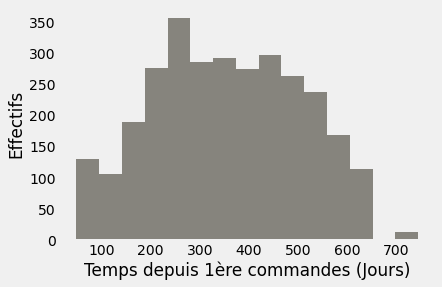

In [38]:

plt.hist(data.days_since_first_order,
         bins=15,
           color="#59564c",
           alpha=0.7)
plt.grid(False, axis='both')
plt.xlabel("Temps depuis 1ère commandes (Jours)")
plt.ylabel("Effectifs")
plt.savefig('plots/tps_depuis_1ere.png',  bbox_inches='tight', dpi=360)

<a id='frequence'></a>
## Fréquence des commandes
Pour représenter la régularité du client. On se basera aussi sur la date virtuelle

Voir la [fonction](#get_frequency)

La fréquence est exprimée par mois

In [39]:
data['frequency'] = data.apply(get_frequency, axis=1)

In [40]:
data['frequency'].describe()

count    2997.000000
mean        0.234270
std         0.167588
min         0.081931
25%         0.133206
50%         0.183912
75%         0.262392
max         1.863520
Name: frequency, dtype: float64

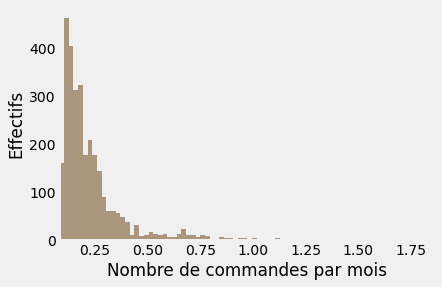

In [41]:
plt.hist(data.frequency, 
                       bins=80,
                       color="#8c704d",
                       alpha=0.7)
# plt.xticks(np.arange(0,1.1,0.1), rotation=90)
plt.xlim([data.frequency.min(),data.frequency.max()])
plt.grid(False, axis='both')
plt.xlabel("Nombre de commandes par mois")
plt.ylabel("Effectifs")
plt.savefig('plots/frequence.png',  bbox_inches='tight', dpi=360)

<a id='montant'></a>
## Montant total des achats 💰

Voir la [fonction](#get_sum_orders)

In [42]:
data['sum_orders'] = data.apply(get_sum_orders, axis=1)

In [43]:
data['sum_orders'].describe()

count    2997.000000
mean      259.867191
std       308.511754
min         0.000000
25%       109.900000
50%       179.890000
75%       303.160000
max      7388.000000
Name: sum_orders, dtype: float64

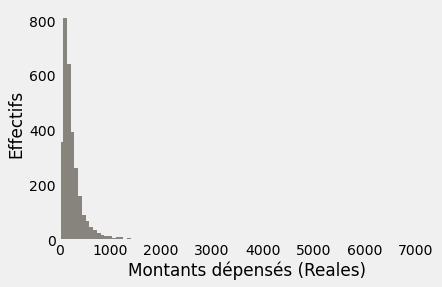

In [44]:
plt.hist(data.sum_orders, 
                       bins=100,
                       color="#59564c",
                       alpha=0.7)
# plt.xticks(np.arange(0,1.1,0.1), rotation=90)
plt.xlim([data.sum_orders.min(),data.sum_orders.max()])
plt.grid(False, axis='both')
plt.xlabel("Montants dépensés (Reales)")
plt.ylabel("Effectifs")
plt.savefig('plots/montants.png',  bbox_inches='tight', dpi=360)

<a id='categorie'></a>
## Catégogie la plus fréquente 🗂️
On essaie ici de détecter le type de produit intéressant le plus le client en prenant la catégoie qu'il a le plus acheté

Voir la [fonction](#get_most_frequent_categ)

In [45]:
len(products.product_category_name.unique())

74

In [46]:
len(products.product_category_name_english.unique()) == len(products.product_category_name.unique())

False

In [47]:
data['favourite_category'] = data.apply(get_most_frequent_categ, axis=1)

fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail


In [48]:
data['favourite_category'].isnull().value_counts()

False    2984
True       13
Name: favourite_category, dtype: int64

In [49]:
data = data.merge(products_categ_traduction, how='left', 
           left_on='favourite_category', right_on='product_category_name').set_axis(data.index)

In [50]:
data.drop(columns=['product_category_name'], inplace=True)

In [51]:
data.rename(columns={'product_category_name_english':'favourite_category_english'}, inplace=True)

In [52]:
data

,nb_orders,orders_ids,days_since_first_order,days_since_last_order,frequency,sum_orders,favourite_category,favourite_category_english
customer_unique_id,,,,,,,,
00172711b30d52eea8b313a7f2cced02,2,"[bb874c45df1a3c97842d52f31efee99a, c306eca42d3...",81,65,0.751543,74.50,papelaria,stationery
004288347e5e88a27ded2bb23747066c,2,"[a61d617fbe5bd006e40d3a0988fc844b, 08204559beb...",447,276,0.136186,317.89,malas_acessorios,luggage_accessories
004b45ec5c64187465168251cd1c9c2f,2,"[90ae229a4addcfead792e2564554f09c, 9392c5e7288...",411,143,0.148114,86.90,moveis_decoracao,furniture_decor
0058f300f57d7b93c477a131a59b36c3,2,"[2cfc79d9582e9135c0a9b61fa60e6b21, 81a93b2fa39...",240,208,0.253646,132.48,malas_acessorios,luggage_accessories
00a39521eb40f7012db50455bf083460,2,"[7d32c87acba91ed87ebd98310fe1c54d, cea3e6c11eb...",146,136,0.416952,81.45,esporte_lazer,sports_leisure
...,...,...,...,...,...,...,...,...
ff36be26206fffe1eb37afd54c70e18b,3,"[b02682757340133856bfb99145dd61cd, 81b7c7bbc8e...",81,55,1.127315,77.90,casa_conforto,home_confort
ff44401d0d8f5b9c54a47374eb48c1b8,2,"[c087855fe6f303205c09558f7f8103c8, e28a4c66f14...",515,515,0.118204,39.80,fashion_bolsas_e_acessorios,fashion_bags_accessories
ff8892f7c26aa0446da53d01b18df463,2,"[cb6e8d89049744886ad04520d5e0b2f6, 1c308eca3f3...",511,324,0.119129,277.95,cama_mesa_banho,bed_bath_table


In [53]:
len(data['favourite_category_english'].unique())

65

Pour réduire la cardinalité nous utilisons une bibliothèque qui permet de trouver des ressemblances entre des catégories

In [54]:
data.columns

Index(['nb_orders', 'orders_ids', 'days_since_first_order',
       'days_since_last_order', 'frequency', 'sum_orders',
       'favourite_category', 'favourite_category_english'],
      dtype='object')

In [55]:
for idx_i, i in enumerate(products_categ_traduction['product_category_name_english'].astype('str').unique()[:-1]):
    for idx_j, j in enumerate(products_categ_traduction['product_category_name_english'].astype('str').unique()[idx_i+1:]):
        similarity_ij = fuzz.WRatio(i, j)
        if similarity_ij >= 70 and similarity_ij != 100:
            print(f'{i} vs {j}: {similarity_ij}%')

computers_accessories vs luggage_accessories: 70%
computers_accessories vs computers: 90%
furniture_decor vs furniture_bedroom: 75%
telephony vs fixed_telephony: 90%
food_drink vs food: 90%
food_drink vs drinks: 82%
small_appliances vs home_appliances: 77%
small_appliances vs home_appliances_2: 73%
small_appliances vs small_appliances_home_oven_and_coffee: 90%
fashion_shoes vs fashion_sport: 77%
construction_tools_construction vs costruction_tools_tools: 74%
construction_tools_construction vs home_construction: 74%
construction_tools_construction vs construction_tools_lights: 71%
construction_tools_construction vs construction_tools_safety: 75%
costruction_tools_garden vs costruction_tools_tools: 77%
costruction_tools_garden vs construction_tools_lights: 78%
costruction_tools_garden vs construction_tools_safety: 82%
fashion_male_clothing vs fashio_female_clothing: 93%
fashion_male_clothing vs fashion_childrens_clothes: 70%
home_appliances vs home_appliances_2: 94%
home_appliances vs sm

In [56]:
data.columns

Index(['nb_orders', 'orders_ids', 'days_since_first_order',
       'days_since_last_order', 'frequency', 'sum_orders',
       'favourite_category', 'favourite_category_english'],
      dtype='object')

In [92]:
data.favourite_category_english = data.favourite_category_english.replace({'computers_accessories':'computers',
                                                                           'furniture_decor':'furniture',
                                                                           'furniture_bedroom':'furniture',
                                                                           'furniture_mattress_and_upholstery':'furniture',
                                                                           'bed_bath_table':'furniture',
                                                                           'kitchen_dining_laundry_garden_furniture':'furniture',
                                                                           'office_furniture':'furniture',
                                                                           'fixed_telephony':'telephony',
                                                                           'food':'food_drink',
                                                                           'drinks':'food_drink',
                                                                           'small_appliances':'appliances',
                                                                           'home_appliances':'appliances',
                                                                           'home_appliances_2':'appliances',
                                                                           'small_appliances_home_oven_and_coffee':'appliances',
                                                                           'fashion_shoes':'fashion',
                                                                           'fashion_sport':'fashion',
                                                                           'fashion_bags_accessories':'fashion',
                                                                           'fashion_underwear_beach':'fashion',
                                                                           'construction_tools_construction':'tools',
                                                                           'costruction_tools_garden':'tools',
                                                                           'garden_tools':'tools',
                                                                           'costruction_tools_tools':'tools',
                                                                           'construction_tools_lights':'tools',
                                                                           'construction_tools_safety':'tools',
                                                                           'fashion_male_clothing':'fashion',
                                                                           'fashio_female_clothing':'fashion',
                                                                           'fashion_childrens_clothes':'fashion',
                                                                           'home_comfort_2':'home_confort',
                                                                           'furniture_living_room':'furniture',
                                                                           'art':'arts_and_craftmanship',
                                                                           'books_general_interest':'books',
                                                                           'books_technical':'books',
                                                                           'books_imported':'books',
                                                                           'perfumery':'health_beauty',
                                                                           'musical_instruments':'music',
                                                                           'agro_industry_and_commerce':'industry',
                                                                           'industry_commerce_and_business':'industry',
                                                                           'computers':'electronics',
                                                                           'telephony':'electronics',
                                                                           'audio':'electronics',
                                                                           'consoles_games':'electronics',
                                                                           'tablets_printing_image':'electronics',
                                                                           'stationery':'arts_and_craftmanship',
                                                                           'cool_stuff':'watches_gifts_toys',
                                                                           'christmas_supplies':'watches_gifts_toys',
                                                                           'toys':'watches_gifts_toys',
                                                                           'watches_gifts':'watches_gifts_toys',
                                                                           'housewares':'home_confort',
                                                                           'appliances':'home_confort',
                                                                           'air_conditioning':'home_confort',
                                                                           'tools':'home_construction',
                                                                           'books':'culture',
                                                                           'music':'culture',
                                                                           'cine_photo':'culture',
                                                                           'dvds_blu_ray':'culture',
                                                                           'diapers_and_hygiene':'health_beauty',
                                                                           'signaling_and_security':'industry',
                                                                           'la_cuisine':'home_confort',
                                                                           'market_place':'other',
                                                                           'luggage_accessories':'fashion',
                                                                           })

Electronics : computers, telephony, audio etc
Stationnery avec arts 
toys, cool_stuff et gifts
fashion et health_beauty


In [93]:
data['favourite_category_english'] = data['favourite_category_english'].fillna('other')

In [94]:
len(data['favourite_category_english'].unique())

16

Certain produits ne sont pas reliés à une catégorie : création d'une catégorie "autre"

In [95]:
data['favourite_category_english'].value_counts()

furniture                783
health_beauty            338
home_confort             338
electronics              323
sports_leisure           320
watches_gifts_toys       285
fashion                  166
home_construction        111
baby                      68
auto                      61
arts_and_craftmanship     57
pet_shop                  53
food_drink                38
culture                   34
other                     16
industry                   6
Name: favourite_category_english, dtype: int64

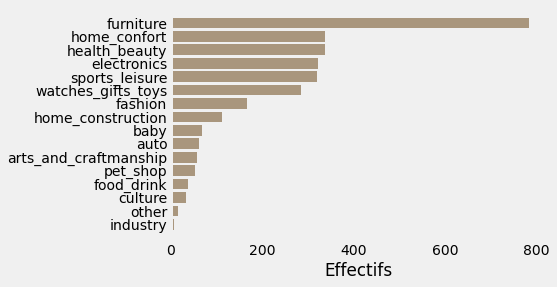

In [104]:
data_bar_categ_fav = data.favourite_category_english.value_counts(ascending=True)
plt.barh(data_bar_categ_fav.index,
        data_bar_categ_fav.values,
        color="#8c704d",
        alpha=0.7)
plt.grid(False, axis='both')
plt.xlabel("Effectifs")
plt.savefig('plots/categ_fav.png',  bbox_inches='tight', dpi=360)

<a id='reviews'></a>
## Nombre d'avis postés et note moyenne⭐
Implication et satisfaction du client sur le site

Voir la [fonction](#get_nb_reviews_and_avg)

In [61]:
data[['nb_reviews', 'average_review_score']] = data.apply(get_nb_reviews_and_avg, axis=1, result_type='expand')

In [62]:
data.nb_reviews.value_counts()

2.0     2424
3.0      405
4.0      125
5.0       23
6.0       13
7.0        5
9.0        1
17.0       1
Name: nb_reviews, dtype: int64

In [63]:
data.nb_orders.value_counts()

2     2745
3      203
4       30
5        8
6        6
7        3
9        1
17       1
Name: nb_orders, dtype: int64

In [64]:
reviews.review_score.value_counts(normalize=True)

5    0.57420
4    0.19200
1    0.11858
3    0.08287
2    0.03235
Name: review_score, dtype: float64

### C'est louche

In [65]:
data.average_review_score.describe()

count    2997.000000
mean        4.098780
std         1.150088
min         1.000000
25%         3.500000
50%         4.500000
75%         5.000000
max         5.000000
Name: average_review_score, dtype: float64

In [66]:
reviews.review_score.isnull().value_counts()

False    100000
Name: review_score, dtype: int64

On note ici que dans cette base, tous les clients écrivent des reviews et donnent des notes

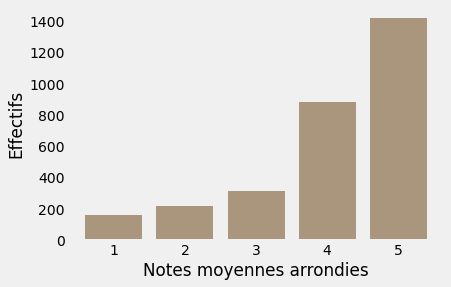

In [67]:
data_bar_reviews_notes = data.average_review_score.round().value_counts()
plt.bar(data_bar_reviews_notes.index,
        data_bar_reviews_notes.values,
        color="#8c704d",
        alpha=0.7)
plt.grid(False, axis='both')
plt.xlabel("Notes moyennes arrondies")
plt.ylabel("Effectifs")
plt.savefig('plots/note_moyenne.png',  bbox_inches='tight', dpi=360)

<a id='mode_paiement_prefere'></a>
## Mode de paiement préféré 💳
Relation du client avec l'argent

Voir la [fonction](#get_favourite_payment_method)

In [68]:
payments.payment_type.value_counts()

credit_card    76795
boleto         19784
voucher         5775
debit_card      1529
not_defined        3
Name: payment_type, dtype: int64

In [69]:
payments.payment_type.isnull().value_counts()

False    103886
Name: payment_type, dtype: int64

In [70]:
data['favourite_payment_type'] = data.apply(get_favourite_payment_method, axis=1).replace('boleto', 'cash')

In [71]:
data['favourite_payment_type'].value_counts()

credit_card    2219
cash            550
voucher         187
debit_card       40
not_defined       1
Name: favourite_payment_type, dtype: int64

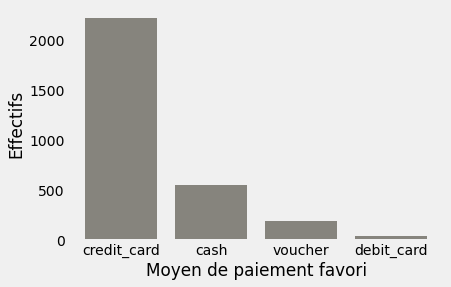

In [75]:
data_bar_payments_notes = data.favourite_payment_type.value_counts().drop(index=['not_defined'])
plt.bar(data_bar_payments_notes.index,
        data_bar_payments_notes.values,
        color="#59564c",
        alpha=0.7)
plt.grid(False, axis='both')
plt.xlabel("Moyen de paiement favori")
plt.ylabel("Effectifs")
plt.savefig('plots/paiements.png',  bbox_inches='tight', dpi=360)

<a id='tps_livraison'></a>
## Temps et retards de livraison 🚚
Expérience logistique du client. pour cette partie nous aurons besoin de créer des variables dans la table "orders"

Nous regarderons le temps moyen de chaque livraison du client et les temps de retard/avance s'il y en a eu

In [76]:
orders['delivery_time'] = orders.order_delivered_customer_date - orders.order_approved_at

In [77]:
orders['delay'] = orders.order_delivered_customer_date - orders.order_estimated_delivery_date

In [78]:
orders['was_delayed'] = orders.delay.map(lambda x : x.days > 1)

In [79]:
orders['was_in_advance'] = orders.delay.map(lambda x : x.days < -1)

Voir la [fonction](#get_delivery_time_and_delays)

In [80]:
data[['average_delivery_time', 'delay_rate', 'advance_rate']] = data.apply(get_delivery_time_and_delays, axis=1, result_type='expand')

In [81]:
data.average_delivery_time.isnull().value_counts()

False    2979
True       18
Name: average_delivery_time, dtype: int64

In [82]:
data.delay_rate.isnull().value_counts()

False    2979
True       18
Name: delay_rate, dtype: int64

Pour les retards non renseignés on replit avec 0

Pour les temps de livraisons non renseingés on met la moyenne des temps moyens des autres clients

In [83]:
data.delay_rate.fillna(0, inplace=True)
data.advance_rate.fillna(0, inplace=True)

In [84]:
data.average_delivery_time.fillna(data.average_delivery_time.mean(), inplace=True)

UFuncTypeError: Cannot cast ufunc 'less' input 1 from dtype('float64') to dtype('<m8[ns]') with casting rule 'same_kind'

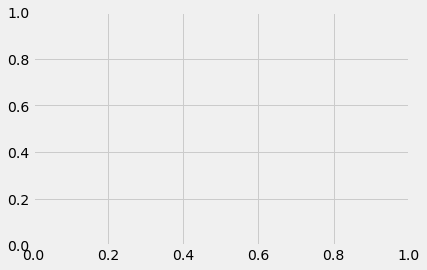

In [85]:
plt.hist(data.average_delivery_time, 
           bins=25,
           color="#8c704d",
           alpha=0.7)

plt.grid(False, axis='both')
plt.xlabel("Tps de livraison (Jours)")
plt.ylabel("Effectifs")
plt.savefig('plots/tps_livraison.png',  bbox_inches='tight', dpi=360)

<a id='annulation'></a>
## Commandes annulées ❌
Capacité du client à aller jusqu'au bout des commandes
Voir la [fonction](#get_cancelation_rate)

In [ ]:
data['cancelation_rate'] = data.apply(get_cancelation_rate, axis=1)

In [ ]:
data['cancelation_rate'].describe()

<a id='model'></a>
# Transformation pour Modélisation ✔️

In [79]:
data

,nb_orders,orders_ids,days_since_first_order,days_since_last_order,frequency,sum_orders,favourite_category,favourite_category_english,nb_reviews,average_review_score,favourite_payment_type,average_delivery_time,delay_rate,advance_rate,cancelation_rate
customer_unique_id,,,,,,,,,,,,,,,
00172711b30d52eea8b313a7f2cced02,2,"[bb874c45df1a3c97842d52f31efee99a, c306eca42d3...",81,65,0.751543,74.50,papelaria,arts_and_craftmanship,2.0,4.000000,voucher,10 days 18:53:22,0.000000,1.000000,0.500000
004288347e5e88a27ded2bb23747066c,2,"[a61d617fbe5bd006e40d3a0988fc844b, 08204559beb...",447,276,0.136186,317.89,cool_stuff,watches_gifts_toys,2.0,5.000000,credit_card,6 days 20:13:13,0.000000,1.000000,0.000000
004b45ec5c64187465168251cd1c9c2f,2,"[90ae229a4addcfead792e2564554f09c, 9392c5e7288...",411,143,0.148114,86.90,ferramentas_jardim,tools,2.0,3.000000,cash,21 days 13:34:03,0.000000,1.000000,0.000000
0058f300f57d7b93c477a131a59b36c3,2,"[2cfc79d9582e9135c0a9b61fa60e6b21, 81a93b2fa39...",240,208,0.253646,132.48,papelaria,arts_and_craftmanship,2.0,3.000000,voucher,13 days 04:37:59,0.000000,1.000000,0.500000
00a39521eb40f7012db50455bf083460,2,"[7d32c87acba91ed87ebd98310fe1c54d, cea3e6c11eb...",146,136,0.416952,81.45,esporte_lazer,sports_leisure,2.0,4.000000,credit_card,17 days 14:40:32,0.000000,1.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ff36be26206fffe1eb37afd54c70e18b,3,"[b02682757340133856bfb99145dd61cd, 81b7c7bbc8e...",81,55,1.127315,77.90,casa_conforto,home_confort,3.0,3.000000,voucher,11 days 22:20:41.890040068,0.000000,0.000000,0.666667
ff44401d0d8f5b9c54a47374eb48c1b8,2,"[c087855fe6f303205c09558f7f8103c8, e28a4c66f14...",515,515,0.118204,39.80,fashion_bolsas_e_acessorios,fashion,2.0,3.000000,voucher,12 days 07:56:58,0.000000,1.000000,0.000000
ff8892f7c26aa0446da53d01b18df463,2,"[cb6e8d89049744886ad04520d5e0b2f6, 1c308eca3f3...",511,324,0.119129,277.95,cama_mesa_banho,furniture,3.0,2.666667,credit_card,36 days 13:47:51,0.500000,0.500000,0.000000


### Simplification de la donnée temporelle (Average delivery time)
On arrondi au jour près

In [80]:
data.average_delivery_time = data.average_delivery_time.map(lambda x : x.round('d').days)

### Conversion des données catégoriques en données numériques

In [81]:
data = pd.concat([data, pd.get_dummies(data.favourite_category_english), pd.get_dummies(data.favourite_payment_type)], axis=1)

In [82]:
data

,nb_orders,orders_ids,days_since_first_order,days_since_last_order,frequency,sum_orders,favourite_category,favourite_category_english,nb_reviews,average_review_score,...,pet_shop,sports_leisure,telephony,tools,watches_gifts_toys,cash,credit_card,debit_card,not_defined,voucher
customer_unique_id,,,,,,,,,,,,,,,,,,,,,
00172711b30d52eea8b313a7f2cced02,2,"[bb874c45df1a3c97842d52f31efee99a, c306eca42d3...",81,65,0.751543,74.50,papelaria,arts_and_craftmanship,2.0,4.000000,...,0,0,0,0,0,0,0,0,0,1
004288347e5e88a27ded2bb23747066c,2,"[a61d617fbe5bd006e40d3a0988fc844b, 08204559beb...",447,276,0.136186,317.89,cool_stuff,watches_gifts_toys,2.0,5.000000,...,0,0,0,0,1,0,1,0,0,0
004b45ec5c64187465168251cd1c9c2f,2,"[90ae229a4addcfead792e2564554f09c, 9392c5e7288...",411,143,0.148114,86.90,ferramentas_jardim,tools,2.0,3.000000,...,0,0,0,1,0,1,0,0,0,0
0058f300f57d7b93c477a131a59b36c3,2,"[2cfc79d9582e9135c0a9b61fa60e6b21, 81a93b2fa39...",240,208,0.253646,132.48,papelaria,arts_and_craftmanship,2.0,3.000000,...,0,0,0,0,0,0,0,0,0,1
00a39521eb40f7012db50455bf083460,2,"[7d32c87acba91ed87ebd98310fe1c54d, cea3e6c11eb...",146,136,0.416952,81.45,esporte_lazer,sports_leisure,2.0,4.000000,...,0,1,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ff36be26206fffe1eb37afd54c70e18b,3,"[b02682757340133856bfb99145dd61cd, 81b7c7bbc8e...",81,55,1.127315,77.90,casa_conforto,home_confort,3.0,3.000000,...,0,0,0,0,0,0,0,0,0,1
ff44401d0d8f5b9c54a47374eb48c1b8,2,"[c087855fe6f303205c09558f7f8103c8, e28a4c66f14...",515,515,0.118204,39.80,fashion_bolsas_e_acessorios,fashion,2.0,3.000000,...,0,0,0,0,0,0,0,0,0,1
ff8892f7c26aa0446da53d01b18df463,2,"[cb6e8d89049744886ad04520d5e0b2f6, 1c308eca3f3...",511,324,0.119129,277.95,cama_mesa_banho,furniture,3.0,2.666667,...,0,0,0,0,0,0,1,0,0,0


### Suppression des colonnes qui ne sont pas utiles pour la modélisation

In [83]:
data.drop(columns=['orders_ids', 'favourite_category', 'favourite_category_english', 'favourite_payment_type'], inplace=True)

In [84]:
data.describe()

,nb_orders,days_since_first_order,days_since_last_order,frequency,sum_orders,nb_reviews,average_review_score,average_delivery_time,delay_rate,advance_rate,...,pet_shop,sports_leisure,telephony,tools,watches_gifts_toys,cash,credit_card,debit_card,not_defined,voucher
count,2997.000000,2997.000000,2997.000000,2997.000000,2997.000000,2997.000000,2997.000000,2997.000000,2997.000000,2997.000000,...,2997.000000,2997.000000,2997.000000,2997.000000,2997.000000,2997.000000,2997.000000,2997.000000,2997.000000,2997.000000
mean,2.116116,355.512846,268.206874,0.234270,259.867191,2.274608,4.098780,11.935936,0.050804,0.908424,...,0.014348,0.098098,0.001335,0.059393,0.122456,0.146480,0.768435,0.020354,0.000334,0.064398
std,0.516610,148.227400,145.352456,0.167588,308.511754,0.705925,1.150088,7.135904,0.169246,0.229860,...,0.118939,0.297497,0.036515,0.236398,0.327866,0.353646,0.421903,0.141231,0.018267,0.245501
min,2.000000,49.000000,0.000000,0.081931,0.000000,2.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,239.000000,152.000000,0.133206,109.900000,2.000000,3.500000,7.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
50%,2.000000,350.000000,248.000000,0.183912,179.890000,2.000000,4.500000,11.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
75%,2.000000,474.000000,366.000000,0.262392,303.160000,2.000000,5.000000,15.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
max,17.000000,744.000000,740.000000,1.863520,7388.000000,17.000000,5.000000,74.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [85]:
# data.to_csv('data/customer_data_v_2.csv')